# SET ENVIRONMENT

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from sklearn import preprocessing
import pandas as pd
import scipy.signal
import pickle
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/AI_in_Medicine_Project/training_set/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AI_in_Medicine_Project/training_set


# LOAD & PLOT DATA

Shape rpeaks: (1857, 1) 
Shape annots: (1857,)


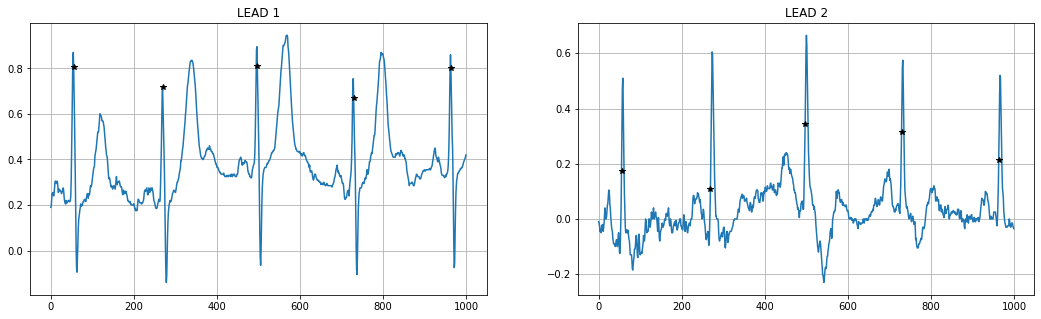

In [4]:
mat = scipy.io.loadmat('S109_250.mat')
mat_ann = scipy.io.loadmat('S109_250_ann.mat')
mat_rpk = scipy.io.loadmat('S109_250_rpk.mat')

signal = mat['ecg']
annots = mat_ann['labels']
rpeaks = mat_rpk['rpeaks']

print('Shape rpeaks: {} \nShape annots: {}'.format(rpeaks.shape, annots.shape))

# First 500 samples of both leads and R peaks
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(signal[:1000,0])
plt.plot(rpeaks[:5], signal[rpeaks[:5],0], 'k*')
plt.title('LEAD 1')
plt.grid()
plt.subplot(1,2,2)
plt.plot(signal[:1000,1] )
plt.plot(rpeaks[:5], signal[rpeaks[:5],1], 'k*')
plt.title('LEAD 2')
plt.grid()


In [5]:
ann_types = np.unique(annots)
print('Types of labels: {}'.format(ann_types))

Types of labels: ['N']


In [6]:
def filter_signal(signal, fs):
    N = 4
    Range = [0.5, 35] 
    Wn = [r/(fs/2) for r in Range]
    b, a = scipy.signal.butter(N, Wn, 'bandpass')
    output_signal = scipy.signal.filtfilt(b, a, signal)
    return output_signal
    

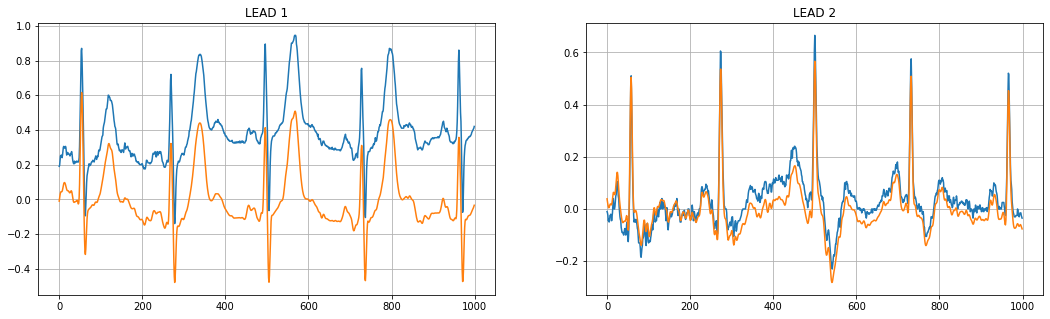

In [7]:
signal_filt_0 = filter_signal(signal[:,0], fs=250)
signal_filt_1 = filter_signal(signal[:,1], fs=250)

# First 500 samples of both leads and R peaks
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(signal[:1000,0])
plt.plot(signal_filt_0[:1000])
plt.title('LEAD 1')
plt.grid()
plt.subplot(1,2,2)
plt.plot(signal[:1000,1])
plt.plot(signal_filt_1[:1000])
plt.title('LEAD 2')
plt.grid()


# CREATE DATASET

This includes taking the R peak positions and splitting the signals into independet ECG beats. The window is fixed -> 35 samples before and after the R peak position. Each peak is normalized between -1 and 1. The ECG beat which is an array is elongated with some values considering the whole signal: 

* Average of RR distances
* Median of RR distances
* Standard deviation of RR distances
------------------------------------

**Additional features**

* logarithm of the current RR distance
* logarithm of the next RR distance
* logarithm of an average RR distance 

The input should be a beat array (70 samples) plus three mentioned features (3 or 6 of them). The output is a label for that beat.  


In [8]:
from scipy.signal import resample

def downsample(signal_orig, rpeaks, signal_fs, fs_new=128):
    
    """ Given the signal and its annotation, downsample the signal and 
        modify the positions of the annotations 
    """
    fs = signal_fs
    
    new_num_samples = int(len(signal_orig)/fs*fs_new)
    downsamp_signal = np.array(resample(signal_orig, new_num_samples))
    
    downsamp_ann = rpeaks/(fs/fs_new)
    downsamp_ann = np.round(downsamp_ann).astype(int)

    return downsamp_signal, downsamp_ann

In [9]:
def calculate_beat_properties(i, peaks):

    """ Given the current peak location and current peak order 
        compute 2 beat features: current and next RR distance dilogarithm 
    """
    # Logarithm current RR distance
    if i==0:
        curr_RR = peaks[i+1]-peaks[i]
        next_RR= curr_RR
    elif i==len(peaks)-1:
        curr_RR = peaks[i] - peaks[i-1]
        next_RR = curr_RR
    else:
        curr_RR = peaks[i]-peaks[i-1]
        next_RR = peaks[i+1]-peaks[i]

    return np.hstack([np.log(curr_RR), np.log(next_RR)])



In [10]:
def calculate_signal_properties(signal, peaks):
    rr_dif = []
    
    for i in range(len(peaks)-1):
        rr_dif_temp = peaks[i+1]-peaks[i]
        rr_dif.append(rr_dif_temp)
        
    # Mean
    mean_RR = np.mean(rr_dif)
    mean_Peaks = np.mean(signal) # Should be 0
    
    # Median
    median_RR = np.median(rr_dif)
    median_Peaks = np.median(signal)

    # Standard deviation
    std_RR = np.std(rr_dif)
    std_Peaks = np.std(signal)

    #   variance
    # var_RR = stats.tvar(rr_dif)
    # var_Peaks = stats.tvar(signal)
    
    # #   Skewness
    # skew_RR = stats.skew(rr_dif)
    # skew_Peaks = stats.skew(signal)

    # #   Kurtosis
    # kurt_RR = stats.kurtosis(rr_dif)
    # kurt_Peaks = stats.kurtosis(signal, axis=0, fisher=True, bias=True)

    # features = np.hstack([mean_RR, mean_Peaks, median_RR, median_Peaks, std_RR, std_Peaks, 
    #                       var_RR, var_Peaks, skew_RR, skew_Peaks, kurt_RR, kurt_Peaks])

    features = np.hstack([mean_RR, mean_Peaks, median_RR, median_Peaks, std_RR, std_Peaks])

    return features

In [11]:
path = '/content/drive/My Drive/AI_in_Medicine_Project/training_set/'
output_path = '/content/drive/My Drive/AI_in_Medicine_Project/'

dataset = []
labels = []
data_path = output_path + 'data'
labels_path = output_path + 'labels'

sample_names = []
lead_num = []
r_peaks_position = []
beat_names = []
signal_features = []
beat_features = []

if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
if not os.path.exists(data_path):
    os.makedirs(data_path)

for _, _, filenames in os.walk(path):    
    for filename in filenames:
        
        if filename[-7:-4]=='rpk' or filename[-7:-4]=='ann':
            continue
        
        # Read three files for each signal 
        mat = scipy.io.loadmat(path+filename)
        mat_rpeaks = scipy.io.loadmat(path+filename[:-4]+'_rpk.mat')
        mat_ann = scipy.io.loadmat(path+filename[:-4]+'_ann.mat')
        
        signal = mat['ecg']
        rpeaks = mat_rpeaks['rpeaks']
        annots = mat_ann['labels'] 
                    
        D = 35   # Distance around R peak

        # ECG Segmentation and Beat Processing
        for lead in [0, 1]:
            signal_lead = signal[:,lead]

            # Compute the current beat properties
            lead_temp = lead
            feature_temp = calculate_signal_properties(signal_lead, rpeaks)
            
             # Resample the signals to 128Hz
            fs = int(filename[-7:-4])
            if fs == 250:
                signal_lead, rpeaks = downsample(signal_lead, rpeaks, fs)

            # Filter the signals
            signal_lead = filter_signal(signal_lead, fs=128)

            for i, position in enumerate(rpeaks):
                position = position[0]
                
                # Check the boundries
                if position-D < 0:
                    beat = signal_lead[:2*D]   
                elif position+D > len(signal_lead)-1:
                    beat = signal_lead[-2*D:]
                else:
                    beat = signal_lead[position-D:position+D] 

                # Normalize the beat between [-1,1]
                beat = (2 *(beat - min(beat))/(max(beat)-min(beat))) - 1

                # Compute beat properties
                beat_features.append(calculate_beat_properties(i, rpeaks))
                
                # Lists of beats (array) and labels 
                dataset.append(beat)
                labels.append(annots[i])
                
                # Save all beats and their annots as individual files
                beat_name = filename[:-4] + '_L' + str(lead) + '_Beat_' + str(i+1)
                beat_path_data = os.path.join(data_path, beat_name)
                beat_path_label = os.path.join(labels_path, beat_name)
                
                #with open(beat_path_data, 'w', newline='') as f:
                 #   wr1 = csv.writer(f, quoting=csv.QUOTE_ALL)
                  #  wr1.writerow(beat)
                
                #with open(beat_path_label, 'w', newline='') as f:
                 #   wr2 = csv.writer(f, quoting=csv.QUOTE_ALL)
                  #  wr2.writerow(annots[i])

                sample_names.append(filename)
                beat_names.append(beat_name)
                r_peaks_position.append(rpeaks)
                lead_num.append(lead_temp)
                signal_features.append(feature_temp)


WITH_FEAT = True

# Data Frame with beats
df_dataset = pd.DataFrame(list(map(np.ravel, dataset)))
df_labels = pd.DataFrame(labels)

if WITH_FEAT == True:

    # Data frame with the properties
    df_signal_properties = pd.DataFrame(signal_features, columns=['mean_RR','mean_Peaks','median_RR','median_Peaks','std_RR','std_Peaks'])
    df_beat_names = pd.DataFrame(beat_names, columns=['beat_name'])
    df_lead = pd.DataFrame(lead_num, columns=['lead_num'])
    df_beat_properties = pd.DataFrame(beat_features, columns=['log_curr_RR','log_next_RR'])

    X = pd.concat([df_lead, df_dataset, df_signal_properties, df_beat_properties], axis = 1)
    y = df_labels

    # Save the Data Frame with beats, their feautures and labels
    df = pd.concat([X, y], axis = 1)
    if not os.path.exists(output_path + 'dataset_with_more_features.csv'):
        df.to_csv(output_path + 'dataset_with_more_features.csv')         

else:
   
    # Save the Data Frame with beats and labels only
    if not os.path.exists(output_path + 'dataset.csv'):
        df.to_csv(output_path + 'dataset.csv')         

        